In [1]:
from IPython.display import display
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from bokeh.plotting import figure, show, gmap
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import viridis
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.io import output_notebook
from ipywidgets import interact
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import requests
import time
import itertools
import os
import glob
import numpy as np
import json
import collections

from config import (
    FS_ACCOUNTS,
    CENSUS_API_KEY,
    GOOGLE_API
)
output_notebook()
%matplotlib inline

Loading BokehJS ...

In [2]:
generate_census_vars = False
generate_fs_vars = False
generate_train_table = False
show_maps = False
tune_params = False

# Generate Geo Features

## US Census Data
- Pulling median household income and gross rent data for census tracts, using [census api](https://www.census.gov/data/developers/data-sets/acs-5year.html)
- Doing a sjoin (between [census tract shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) and airbnb lat, long) to assign variables to our aibnb observations 

In [3]:
if generate_census_vars:
    # Import all train and test independent variables
    train_data = pd.read_csv('../data/raw/train.csv')
    test_data = pd.read_csv('../data/raw/test.csv')
    variables = ['id', 'latitude', 'longitude', 'city']
    all_lat_long = pd.concat([train_data[variables], test_data[variables]])
    display(all_lat_long.shape[0])

    # Setting up parameters for our for loop and census requests
    state_dict = {
        'NYC': '36',
        'SF': '06',
        'DC': '11',
        'LA': '06',
        'Chicago': '17',
        'Boston': '25'
    }
    variable = 'B25064_001E'
    variable_name = 'mean_gross_rent'
    #'B25064_001E' --> mean gross rent -- mean_gross_rent
    #'B08135_001E'--> aggregate time to work (transportation) --> time_to_work
    #'B19013_001E' --> median household income --> median_household_income

    for city_state in state_dict.items():
        city_name = city_state[0]
        state = city_state[1]
        file = '../data/processed/{}_{}.csv'.format(variable_name, city_name.lower().replace(' ','_'))
        print('########## Starting run for {}'.format(city_name))

        # Pulling data from the US census
        if os.path.exists(file) == False:
            url = 'https://api.census.gov/data/2018/acs/acs5?get={}&for=tract:*&in=state:{}&key={}'.format(variable, state, CENSUS_API_KEY)
            response = requests.get(url)
            rent_tract = pd.DataFrame(
                json.loads(response.text), 
                columns=[variable_name, 'state', 'county', 'tract']
            ).drop(0)

            # Reading shapefiles for tracts
            tract_geo = gpd.read_file('../data/raw/cb_2018_{}_tract_500k/'.format(state))
            tract_geo = tract_geo.merge(rent_tract, left_on=['TRACTCE', 'COUNTYFP'], right_on=['tract', 'county'], how='left')

            # Filtering aibnb data for a specific city
            city_data = all_lat_long.loc[all_lat_long.city == city_name]
            city_data = city_data.assign(geometry = [Point(x,y) for (x,y) in zip(city_data.longitude, city_data.latitude)])
            city_geo = gpd.GeoDataFrame(city_data, crs={'init': 'epsg:4326'})
            city_geo = city_geo.to_crs(tract_geo.crs)
            city_obs = city_geo.shape[0]

            # Sjoin to assign rent variable to airbnb lat/long
            city_gross_rent = gpd.sjoin(tract_geo, city_geo, how='right', op='contains')
            after_merge_obs = city_gross_rent.shape[0]
            if city_obs == after_merge_obs:
                print('All good!')
            else:
                print('Error. Before:{}, after:{}'.format(str(city_obs), str(after_merge_obs)))

            # Export to df
            export_vars = ['id', 'state','county','tract',variable_name]
            city_gross_rent[export_vars].to_csv(
                file,
                index=False
            )
        else:
            print('File already exists')

    # Re-reading files and concatenating
    all_files = glob.glob('../data/processed/{}*'.format(variable_name))
    all_file = '../data/processed/{}_all.csv'.format(variable_name)
    try:
        all_files.remove(all_file)
    except:
        print('No "all" file')
    rent_var = []
    for file in all_files:
        rent_var.append(pd.read_csv(file))
        os.remove(file)

    rent_var = pd.concat(rent_var)
    rent_var.loc[rent_var[variable_name] == -666666666, variable_name] = np.nan

    display(rent_var.shape)
    display(rent_var.loc[rent_var.isnull().any(axis=1)].shape)

    rent_var.to_csv('../data/processed/{}_all.csv'.format(variable_name),
                    index=False
                   )

## FS Data
- Finding census tracts where our airbnb observations lie (to reduce the number of petitions to FS API) and searching for centoids for those tracts. Instead of doing 100K petitions (one for each airbnb observation) I do ~4K (one for each tract)
- Pulling historical sites, entertainment and parks data from foursquare [venue search api](https://developer.foursquare.com/docs/api-reference/venues/search/) for our ~4k centroids

In [4]:
if generate_fs_vars:
    ##### FINDING CENSUS TRACTS
    state_dict = {
        'NYC': '36',
        'SF': '06',
        'DC': '11',
        'LA': '06',
        'Chicago': '17',
        'Boston': '25'
    }
    # Import all train and test independent variables
    train_data = pd.read_csv('../data/raw/train.csv')
    test_data = pd.read_csv('../data/raw/test.csv')
    variables = ['id', 'latitude', 'longitude', 'city']
    all_lat_long = pd.concat([train_data[variables], test_data[variables]])

    all_geoid_to_id = []
    all_unique_airbnb_tracts = []
    for city_state in state_dict.items():
        city_name = city_state[0]
        state = city_state[1]
        print('########## Starting run for {}'.format(city_name))
        tract_geo = gpd.read_file('../data/raw/cb_2018_{}_tract_500k/'.format(state))
        city_data = all_lat_long.loc[all_lat_long.city == city_name]
        city_data = city_data.assign(geometry = [Point(x,y) for (x,y) in zip(city_data.longitude, city_data.latitude)])
        city_geo = gpd.GeoDataFrame(city_data, crs={'init': 'epsg:4326'})
        city_geo = city_geo.to_crs(tract_geo.crs)
        tracts_in_airbnb = gpd.sjoin(tract_geo, city_geo, how='inner', op='contains')
        geoid_to_id = tracts_in_airbnb[['GEOID', 'id']]
        tracts_in_airbnb = tracts_in_airbnb.drop(['index_right', 'id', 'latitude', 'longitude'], axis=1)
        tracts_in_airbnb = tracts_in_airbnb.drop_duplicates()
        tracts_in_airbnb = tracts_in_airbnb.assign(
            area = tracts_in_airbnb.geometry.map(lambda x: x.area),
            centroid = tracts_in_airbnb.geometry.map(lambda x: x.centroid)
        )
        all_geoid_to_id.append(geoid_to_id)
        all_unique_airbnb_tracts.append(tracts_in_airbnb)

    all_geoid_to_id = pd.concat(all_geoid_to_id)
    all_unique_airbnb_tracts = pd.concat(all_unique_airbnb_tracts)

    all_unique_airbnb_tracts = all_unique_airbnb_tracts.assign(
        longitude = all_unique_airbnb_tracts.centroid.map(lambda x: x.x),
        latitude = all_unique_airbnb_tracts.centroid.map(lambda x: x.y)
    )

    all_geoid_to_id.to_csv('../data/processed/geoid_to_airbnb_id.csv',
                           index=False,
                           quoting=csv.QUOTE_ALL
                          )

    all_unique_airbnb_tracts[['GEOID', 'longitude', 'latitude']].to_csv(
        '../data/processed/only_airbnb_tracts_centroids.csv',
        index=False,
        quoting=csv.QUOTE_ALL
    )

    ##### PULLING INFO FROM FS
    query_coords = pd.read_csv('../data/processed/only_airbnb_tracts_centroids.csv',
                               dtype={'GEOID': str}
                              )
    # Choosing site categories that we want to query https://developer.foursquare.com/docs/build-with-foursquare/categories/
    fs_categories = {
        'historic_site': '4deefb944765f83613cdba6e',
        'art_museum': '4bf58dd8d48988d18f941735',
        'history_museum': '4bf58dd8d48988d190941735',
        'planetarium': '4bf58dd8d48988d192941735',
        'science_museum': '4bf58dd8d48988d191941735',
        'opera_house': '4bf58dd8d48988d136941735',
        'theater': '4bf58dd8d48988d137941735',
        'outdoor_sculpture': '52e81612bcbc57f1066b79ed',
        'street_art': '52e81612bcbc57f1066b79ee',
        'zoo': '4bf58dd8d48988d17b941735',
        'city_hall': '4bf58dd8d48988d129941735',
        'park': '4bf58dd8d48988d163941735'
    }
    category_ids = ','.join(fs_categories.values())
    version = '20200914'
    radius = 700
    failed_geoid_file = '../data/interim/fs_data/turistic_sites_700m/failed_geoid.txt'
    url = "https://api.foursquare.com/v2/venues/search"
    n_account = 0

    # Creating a file to save all failed runs
    with open(failed_geoid_file, 'w') as outfile:
        json.dump([], outfile)

    def append_failed_run(failed_geoid_file, geoid):
        with open(failed_geoid_file) as json_file:
            failed_geoids = json.load(json_file)
        failed_geoids.append(geoid)
        with open(failed_geoid_file, 'w') as outfile:
            json.dump(failed_geoids, outfile)

    for i,coord in enumerate(query_coords.itertuples()):
        # Need to loop over many fs accounts because I have a petition limit of 900 per day
        valid_account = FS_ACCOUNTS[n_account]
        client_id = valid_account['client_id']
        client_secret = valid_account['client_secret']
        geoid = coord.GEOID
        lat = coord.latitude
        long = coord.longitude
        geoid_out_file = '../data/interim/fs_data/turistic_sites_700m/{}.txt'.format(geoid)
        if os.path.exists(geoid_out_file) == False:
            print('####### {}. Starting request for GEOID {}'.format(i, geoid))
            lat_long = '{},{}'.format(str(lat), str(long))
            params = {
                'client_id': client_id,
                'client_secret': client_secret,
                'll': lat_long,
                'radius':radius,
                'limit':50,
                'categoryId':category_ids,
                'v': version
            }

            response = requests.get(url, params=params)
            if response.status_code == 200: 
                response_json = json.loads(response.text)
                with open(geoid_out_file, 'w') as outfile:
                    json.dump(response_json, outfile)
                print('Success')
            elif (response.status_code == 429) & (n_account + 1 < len(FS_ACCOUNTS)):
                # If request failed because I've surpassed my daily petition limit then try with another account
                n_account += 1
                valid_account = FS_ACCOUNTS[n_account]
                params['client_id'] = valid_account['client_id']
                params['client_secret'] = valid_account['client_secret']
                response = requests.get(url, params=params)
                if response.status_code == 200: 
                    response_json = json.loads(response.text)
                    with open(geoid_out_file, 'w') as outfile:
                        json.dump(response_json, outfile)
                    print('Changed key, success')
                else:
                    print('Failed, status code: {}'.format(str(response.status_code)))
                    append_failed_run(failed_geoid_file, geoid)
            elif (n_account + 1 >= len(FS_ACCOUNTS)):
                break
            else:
                print('Failed, status code: {}'.format(str(response.status_code)))
                append_failed_run(failed_geoid_file, geoid)
        else:
            print('####### {}. Request for GEOID {} already exists'.format(i,geoid))
    
    # Parsing all the response files
    all_files = glob.glob('../data/interim/fs_data/turistic_sites_700m/*')
    all_files.remove(failed_geoid_file)
    all_fs_data = []
    for i, file in enumerate(all_files):
        print(i)
        geoid = file.replace('../data/interim/fs_data/turistic_sites_700m/','').replace('.txt','')
        # Parse jsons
        with open(file) as json_file:
            geoid_json = json.load(json_file)
        all_venues = geoid_json['response']['venues']
        for venue_data in all_venues:
            parsed_venue = {}
            parsed_venue['id'] = venue_data['id']
            location = venue_data.get('location', np.nan)
            if location != np.nan:
                parsed_venue['lat'] = location.get('lat', np.nan)
                parsed_venue['lng'] = location.get('lng', np.nan)
                parsed_venue['distance'] = location.get('distance', np.nan)
                parsed_venue['postal_code'] = location.get('postalCode', np.nan)
                parsed_venue['city'] = location.get('city', np.nan)
                parsed_venue['state'] = location.get('state', np.nan)
            categories = venue_data.get('categories', np.nan)
            for cat in categories:
                cat_ids = []
                cat_name = []
                cat_ids.append(cat['id'])
                cat_name.append(cat['name'])
            parsed_venue['cat_ids'] = ','.join(cat_ids)
            parsed_venue['cat_names'] = ','.join(cat_name)
            parsed_venue['geoid'] = geoid
            df_res = pd.DataFrame(parsed_venue, index=[0])
            all_fs_data.append(df_res)

    all_fs_data = pd.concat(all_fs_data)
    all_fs_data.to_csv('../data/processed/fs_data_turistic700m_geoid.csv',
                       index=False
                      )
    fs_agg_data = all_fs_data.groupby(['geoid', 'cat_names']).agg({'id':'count'}).reset_index()
    fs_agg_data = fs_agg_data.rename(columns={
        'geoid': 'GEOID',
        'id': 'total'
    })
    geoid_to_id = pd.read_csv(
        '../data/processed/geoid_to_airbnb_id.csv',
        dtype={'GEOID': str}
    )
    display(geoid_to_id.shape[0])
    geoid_to_id_m = geoid_to_id.merge(fs_agg_data, how='left')
    geoid_to_id_m = geoid_to_id_m.pivot_table(index='id', columns='cat_names', values='total', fill_value=0).reset_index()
    geoid_to_id_m.columns = [column.lower().replace(' ','_') for column in geoid_to_id_m.columns]
    geoid_to_id = geoid_to_id.merge(geoid_to_id_m, how='left')
    geoid_to_id = geoid_to_id.fillna(0)
    all_cols = list(geoid_to_id.columns)
    all_cols.remove('id')
    geoid_to_id = geoid_to_id.assign(total_entertainment = geoid_to_id[all_cols].sum(axis=1))
    geoid_to_id.to_csv('../data/processed/fs_agg_data_airbnb_id_turism700m.csv',
                       index=False
                      )

# Create Modeling Table

In [5]:
train_data = pd.read_csv(
    '../data/raw/train.csv',
    parse_dates=['first_review','host_since', 'last_review']
)

# Leaving out 10% of the data to test once the model is finished
if generate_train_table:
    test_data = train_data.sample(frac=0.1)
    test_data.to_csv('../data/raw/test_lore.csv',
                     index=False
                    )

test_data = pd.read_csv('../data/raw/test_lore.csv')
train_data = train_data.loc[~train_data.id.isin(test_data.id)]
display(train_data.shape)
household_data = pd.read_csv(
    '../data/processed/median_household_income_all.csv',
    usecols = ['id', 'median_household_income']
)
rent_data = pd.read_csv(
    '../data/processed/mean_gross_rent_all.csv',
    usecols = ['id', 'mean_gross_rent']
)
fs_data = pd.read_csv(
    '../data/processed/fs_agg_data_airbnb_id_entertainment1000m.csv',
    dtype={'GEOID':str},
    usecols=['GEOID', 'id', 'park']
)
fs_data_entertainment = pd.read_csv(
    '../data/processed/fs_agg_data_airbnb_id_turism700m.csv',
    dtype={'GEOID':str}
)
train_data = train_data.merge(household_data, on=['id'], how='left')
display(train_data.shape)
train_data = train_data.merge(fs_data, on=['id'], how='left')
display(train_data.shape)
train_data = train_data.merge(fs_data_entertainment, on=['id','GEOID'], how='left')
display(train_data.shape)
train_data = train_data.merge(rent_data, on=['id'], how='left')
display(train_data.shape)

(66700, 29)

(66700, 30)

(66700, 32)

(66700, 33)

(66700, 34)

In [6]:
display(train_data.shape)
display(train_data.dtypes)

(66700, 34)

id                                  int64
log_price                         float64
property_type                      object
room_type                          object
amenities                          object
accommodates                        int64
bathrooms                         float64
bed_type                           object
cancellation_policy                object
cleaning_fee                         bool
city                               object
description                        object
first_review               datetime64[ns]
host_has_profile_pic               object
host_identity_verified             object
host_response_rate                 object
host_since                 datetime64[ns]
instant_bookable                   object
last_review                datetime64[ns]
latitude                          float64
longitude                         float64
name                               object
neighbourhood                      object
number_of_reviews                 

# Transform Data

In [7]:
last_date = train_data.host_since.max()
train_data = train_data.assign(
    host_response_rate = train_data.host_response_rate.str.replace('%','').str.strip().astype(float),
    zipcode = train_data.zipcode.replace("''",np.nan).str.replace('\.0',''),
    amenities_list = train_data.amenities.str.replace(
    '{','').str.replace(
    '}','').str.replace(
    '"','').map(lambda x: x.split(',')),
    days_airbnb_host = (last_date - train_data.host_since).dt.days,
)

## Amenities

In [8]:
unique_amenities_list = []
all_amenities_list = []
for row in train_data.itertuples():
    train_set = set(row.amenities_list)
    am_set = set(unique_amenities_list)
    missing = list(train_set - am_set)
    unique_amenities_list += missing
    all_amenities_list += row.amenities_list

In [9]:
counter = collections.Counter(all_amenities_list)
amenity_count = pd.DataFrame().from_dict(dict(counter),orient='index',columns=['total'])

In [10]:
# Create indicator for top 10 amenities
top_amenities = list(amenity_count.sort_values('total', ascending=False).head(10).index)
top_amenities = top_amenities
# Creating one column for each amenity
for amenity in top_amenities:
    train_data[amenity] = '0'
# Inputing 1 for listings that have the amenity
for index_label, row in train_data.iterrows():
    for amenity in top_amenities:
        if amenity in row.amenities_list:
            train_data.at[index_label, amenity] = '1'
            
train_data.columns = [column.lower().replace(' ','_') for column in train_data.columns]
top_amenities = [column.lower().replace(' ','_') for column in top_amenities]

# Dig Into Missing Values

<AxesSubplot:>

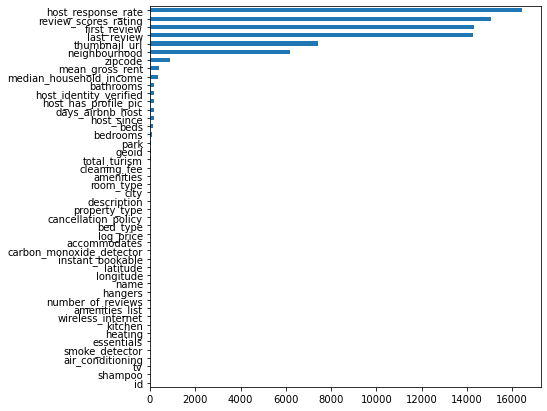

In [11]:
fig, axs = plt.subplots(figsize=(7,7))
train_data.isnull().sum().sort_values(ascending=True).plot(kind='barh', ax=axs)

## Host response rate

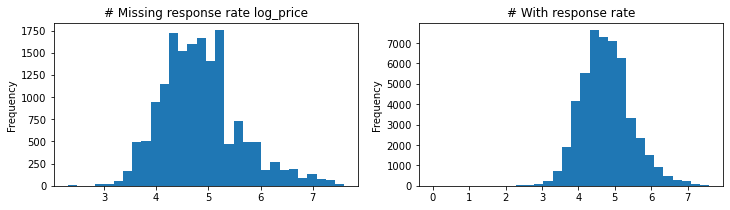

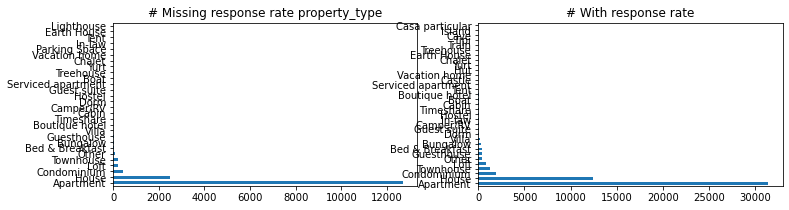

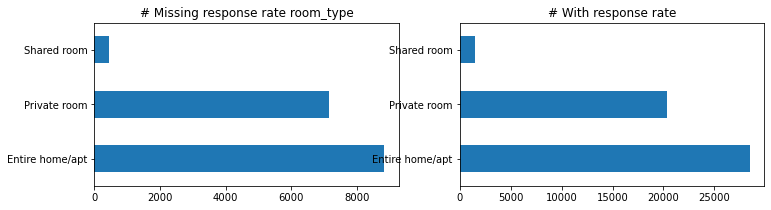

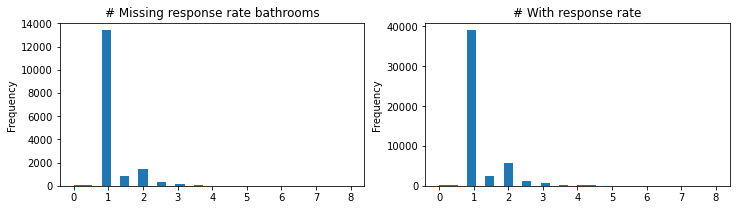

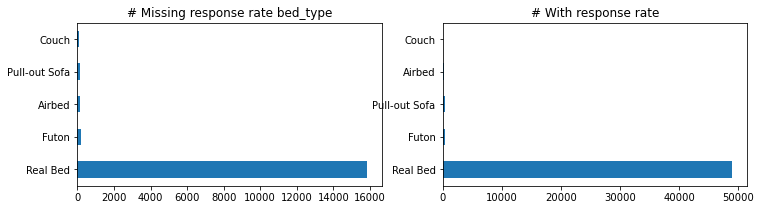

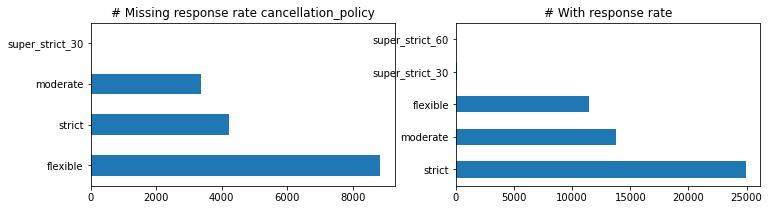

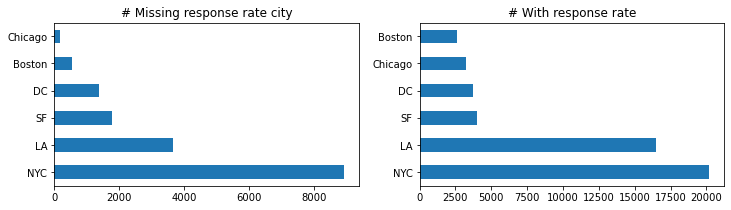

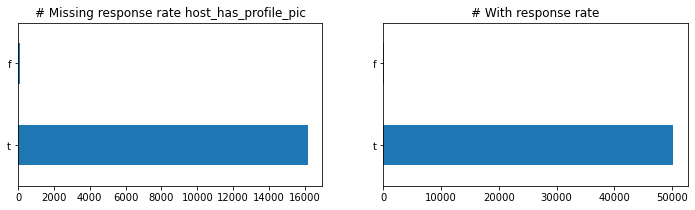

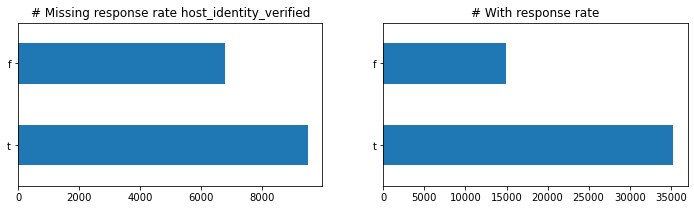

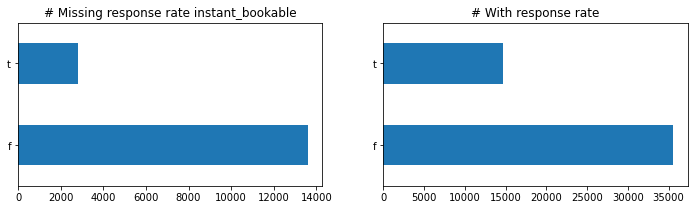

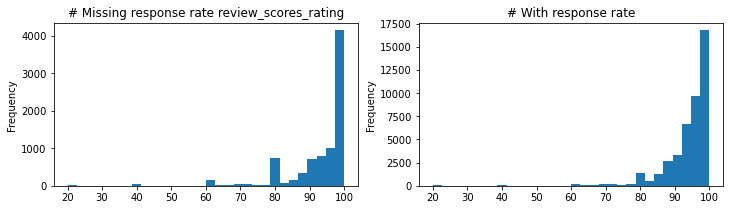

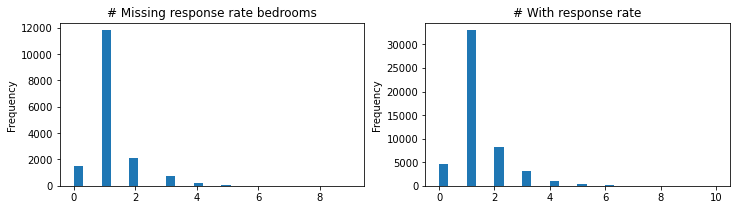

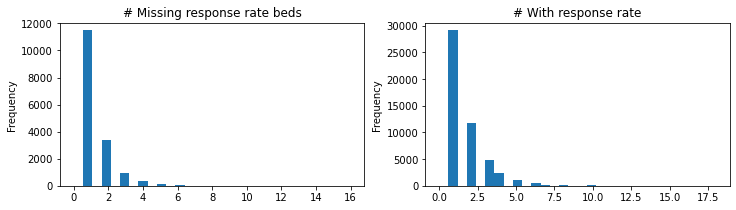

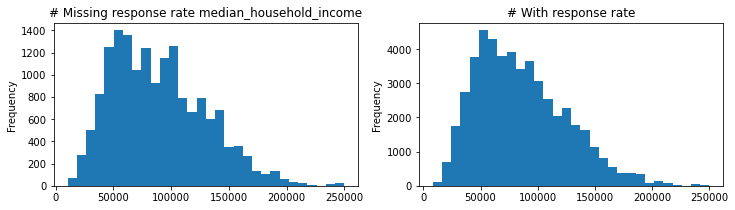

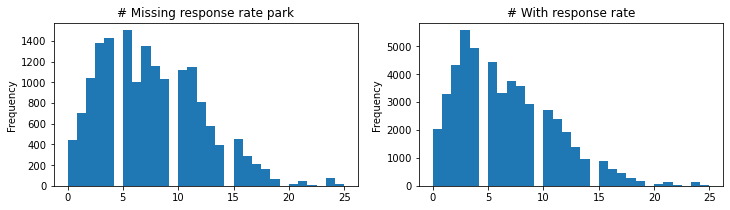

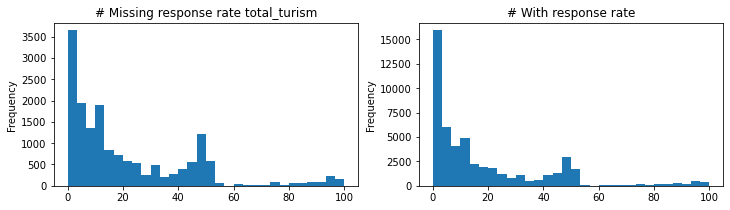

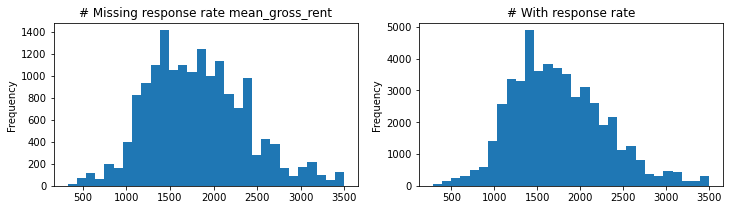

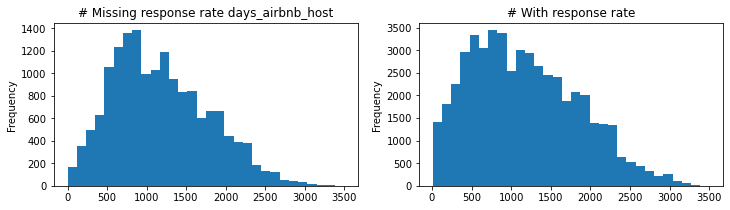

In [12]:
# Plotting all relevant variables for observations that have NA in host_response_rate vs. those that have a non NA value
all_cols = list(train_data.columns)
plot_cols = [col for col in all_cols if col not in [
    'longitude', 'latitude', 
    'host_response_rate', 'id', 
    'name', 'description', 'amenities',
    'amenities_list','thumbnail_url',
    'zipcode', 'neighbourhood', 'geoid'
] + top_amenities]
for var in plot_cols:
    aux = var
    data_type = train_data[var].dtype
    if data_type.type == np.float64:
        plot_kind = 'hist'
        kwargs = {'bins':30}
    elif data_type.type == np.object_:
        plot_kind = 'barh'
        kwargs = {}
    else:
        continue
    fig, axs = plt.subplots(figsize=(12,3), ncols=2)
    missing_d = train_data.loc[train_data.host_response_rate.isnull(),var]
    non_missing_d = train_data.loc[~train_data.host_response_rate.isnull(),var]
    if plot_kind == 'barh':
        non_missing_d = non_missing_d.value_counts()
        missing_d = missing_d.value_counts()
    missing_d.plot(kind=plot_kind,ax=axs[0],**kwargs)
    axs[0].set_title('# Missing response rate {}'.format(var))
    non_missing_d.plot(kind=plot_kind,ax=axs[1],**kwargs)
    axs[1].set_title('# With response rate')

**Conclusion**: listings with missing response rate seem to have lower price than those who do have it, other features seem pretty similar

## Review scores rating

,number_of_reviews,review_scores_rating


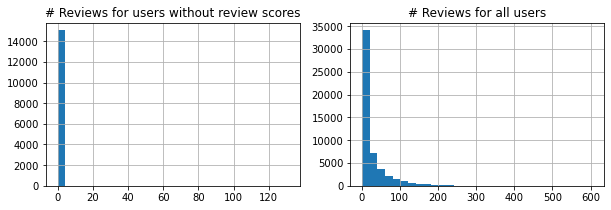

In [13]:
fig, axs = plt.subplots(figsize=(10,3), ncols=2)
train_data.loc[train_data.review_scores_rating.isnull(), 'number_of_reviews'].hist(bins=30, ax=axs[0])
axs[0].set_title('# Reviews for users without review scores')
train_data.loc[~train_data.review_scores_rating.isnull(), 'number_of_reviews'].hist(bins=30, ax=axs[1])
axs[1].set_title('# Reviews for all users')

filter_ = (train_data.number_of_reviews == 0) & (~train_data.review_scores_rating.isnull())
display(train_data.loc[filter_, ['number_of_reviews', 'review_scores_rating']])

In [14]:
filter_ = (train_data.number_of_reviews == 0) & (~train_data.first_review.isnull())
train_data.loc[filter_, ['number_of_reviews', 'first_review']]

,number_of_reviews,first_review


In [15]:
train_data['review_scores_rating'] = train_data.review_scores_rating.fillna(train_data.review_scores_rating.min())

**Conclusion**: All users that have NA for review_score_rating, first_review and last_review have cero reviews

# EDA

## Price

count    66700.000000
mean         4.782173
std          0.716774
min          0.000000
25%          4.317488
50%          4.718499
75%          5.220356
max          7.600402
Name: log_price, dtype: float64

<AxesSubplot:>

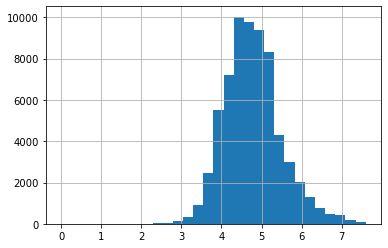

In [16]:
display(train_data.log_price.describe())
train_data.log_price.hist(bins=30)

In [17]:
# Looks like there was an error with a listing
train_data = train_data.loc[train_data.log_price != 0]

In [18]:
if show_maps:
    map_var = 'log_price'
    location_df = train_data.loc[:,['latitude', 'longitude', map_var]]
    location_df = location_df.loc[(location_df.log_price > 2) & (location_df.log_price < 7.5)]
    location_ds = ColumnDataSource(location_df)
    mapper = LinearColorMapper(
        palette=viridis(256),
        low=location_df[map_var].min(),
        high=location_df[map_var].max()
    )
    map_options = GMapOptions(lat=37.774, lng=-122.431, map_type="roadmap", zoom=5)
    p = gmap(GOOGLE_API, map_options, title=map_var.replace('_', ' '))
    p.circle('longitude', 'latitude',
             source=location_ds,
             size=20,
             alpha=0.5,
             fill_color={"field":map_var, "transform":mapper}
            )
    show(p)

**Conclusion**: Price does change a lot depending on where the Airbnb is located (as expected)

In [19]:
def plot_categorical(x_var):
    plt.figure(figsize=(20,7))
    sns.violinplot(x=x_var, y='log_price', data=train_data)
    plt.title(x_var.replace('_',' '))

cat_variables = [
    'room_type', 'property_type', 'accommodates',
    'bathrooms', 'bed_type', 'cancellation_policy',
    'cleaning_fee', 'city', 'host_has_profile_pic',
    'host_identity_verified', 'instant_bookable',
    'review_scores_rating', 'bedrooms', 'beds',
    'review_cat', 'review_round', 'host_response_rate_round'
] + top_amenities
interact(plot_categorical, x_var=cat_variables)

interactive(children=(Dropdown(description='x_var', options=('room_type', 'property_type', 'accommodates', 'ba…

<function __main__.plot_categorical(x_var)>

**Conclusion**: Variables that seem to matter the most are room_type, accommodates, bathrooms, bedrooms, beds, cleaning_fee and tv

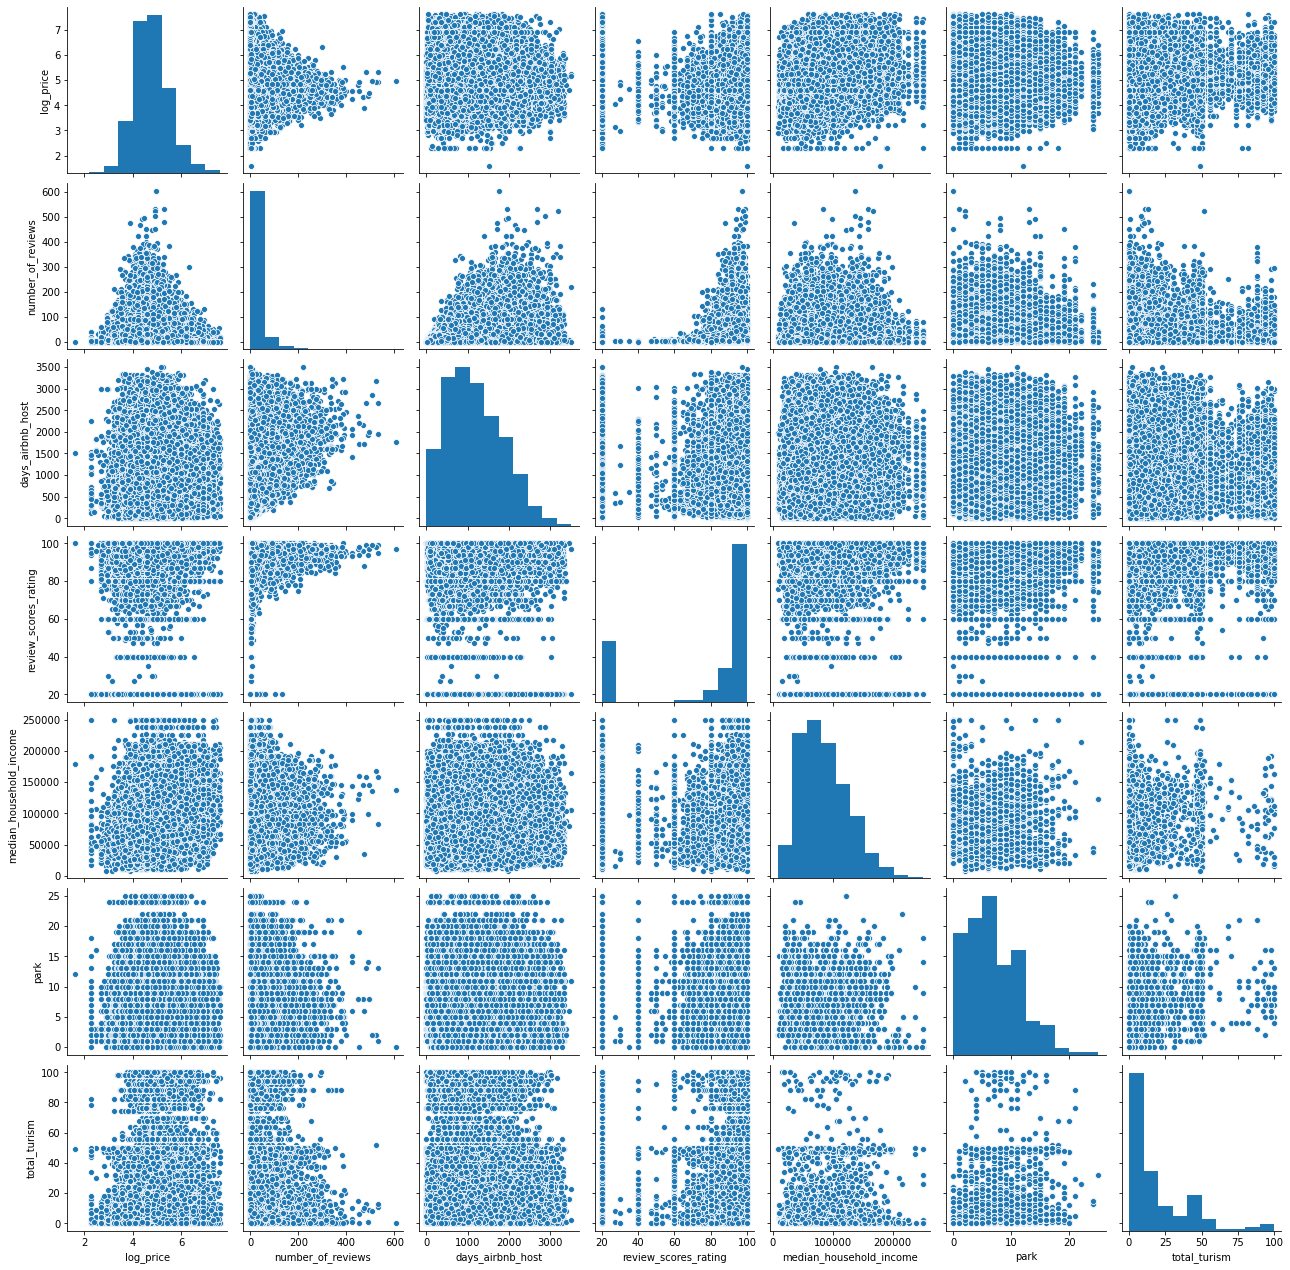

In [20]:
num_columns = [
    'log_price', 'number_of_reviews', 
    'days_airbnb_host', 'review_scores_rating', 
    'median_household_income',
    'park', 'total_turism'
]
sns.pairplot(train_data[num_columns])

In [21]:
train_data[num_columns].var().sort_values(ascending=False)

median_household_income    1.567302e+09
days_airbnb_host           4.378908e+05
number_of_reviews          1.428563e+03
review_scores_rating       1.006880e+03
total_turism               4.810423e+02
park                       2.008079e+01
log_price                  5.134302e-01
dtype: float64

## Correlations

<AxesSubplot:>

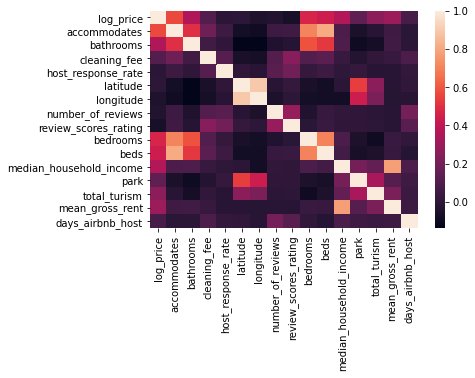

In [22]:
sns.heatmap(train_data.drop(['id']+top_amenities, axis=1).corr())

# Combining and transforming features

## Bed Type

<AxesSubplot:xlabel='real_bed', ylabel='log_price'>

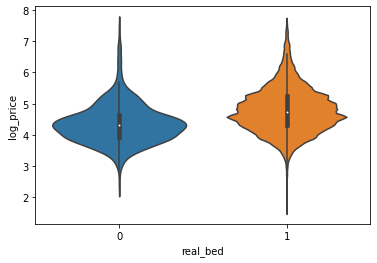

In [23]:
train_data = train_data.assign(
    real_bed = np.where(train_data.bed_type == 'Real Bed', 1, 0)
)

sns.violinplot(
    x='real_bed', 
    y='log_price', 
    data=train_data
)

## Property Type

<AxesSubplot:xlabel='hostel_or_gh', ylabel='log_price'>

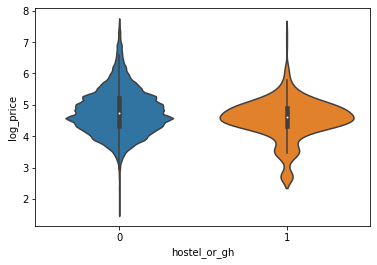

In [24]:
train_data = train_data.assign(
    hostel_or_gh = np.where(
        train_data.property_type.isin(['Hostel', 'Guesthouse']),
        1,0)
)
sns.violinplot(
    x='hostel_or_gh', 
    y='log_price', 
    data=train_data
)

## Host

<AxesSubplot:xlabel='strict_cancellation', ylabel='log_price'>

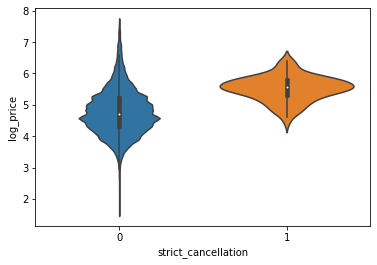

In [25]:
train_data = train_data.assign(
    strict_cancellation = np.where(
        train_data.cancellation_policy.isin(['super_strict_30', 'super_strict_30']), 1 ,0)
)
sns.violinplot(
    x='strict_cancellation', 
    y='log_price', 
    data=train_data
)

In [26]:
train_data = train_data.assign(
    host_identity_verified = np.where(train_data.host_identity_verified == 't',1,0),
    num_reviews_over_3 = np.where(train_data.number_of_reviews > 3, 1,0),
    review_rating_over_80 = np.where(train_data.review_scores_rating > 80, 1,0)
)

train_data = train_data.assign(
    host_score = 0.3 * train_data.host_identity_verified + \
    train_data.num_reviews_over_3 * 0.35 + train_data.review_rating_over_80 * 0.35
)
train_data = train_data.drop(['host_identity_verified', 'num_reviews_over_3', 'review_rating_over_80'], axis=1)

## Amenities

In [27]:
train_data = train_data.assign(
    total_amenities = np.log(train_data.amenities_list.map(lambda x: len(x)) + 1)
)

<AxesSubplot:ylabel='Frequency'>

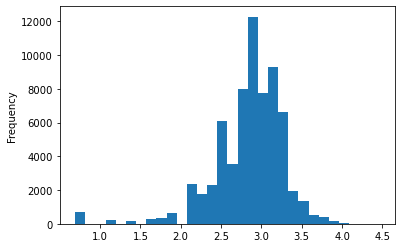

In [28]:
train_data.total_amenities.plot(kind='hist', bins=30)

,total_amenities,log_price
total_amenities,1.000000,0.176145
log_price,0.176145,1.000000


<AxesSubplot:xlabel='total_amenities', ylabel='log_price'>

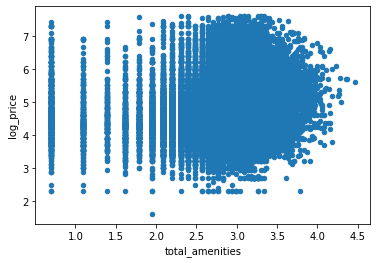

In [29]:
display(train_data[['total_amenities', 'log_price']].corr())
train_data[['total_amenities', 'log_price']].plot(kind='scatter', x='total_amenities', y='log_price')

# Model
Results from all models that I ran [here](https://docs.google.com/spreadsheets/d/1WpR_OcSXi7go25DpZKEfjAO7UfHEOoiw47gho5Ey2FA/edit?usp=sharing)

In [30]:
x_vars_cat_t = ['room_type']
x_vars_cat_nt = [
    'tv', 'real_bed', 
    'kitchen', 
    'strict_cancellation',
    'hostel_or_gh', 
    
]
x_vars_cat = x_vars_cat_t + x_vars_cat_nt
x_vars_bool = ['cleaning_fee']
x_vars_num = [
    'accommodates', 'bathrooms', 'bedrooms', 
    'median_household_income', 'park',
    'total_amenities',
    'beds', 'host_score',
    'total_turism', 'mean_gross_rent'
]
x_vars = x_vars_cat + x_vars_num + x_vars_bool
y_var = ['log_price']
unique_id = ['id']
model_type = 'non_linear'

In [31]:
train_data = train_data.assign(county_geoid = train_data.geoid.str.slice(0,5))
train_data = train_data.assign(
    median_household_income = train_data.median_household_income.fillna(
        train_data.groupby('county_geoid')['median_household_income'].transform('mean')),
    park = train_data.park.fillna(
        train_data.groupby('county_geoid')['park'].transform('mean')),
    mean_gross_rent = train_data.mean_gross_rent.fillna(
        train_data.groupby('county_geoid')['mean_gross_rent'].transform('mean'))
)

In [32]:
train_data_index = train_data.set_index(unique_id)
for col in x_vars_cat_t:
    train_data_index[col] = train_data_index[col].str.replace(' ','_').str.lower()
room_dummies = pd.get_dummies(train_data_index['room_type'], prefix='room', drop_first=True)
train_data_index[x_vars_bool] = train_data_index[x_vars_bool]*1
train_data_index[x_vars_cat_nt] = train_data_index[x_vars_cat_nt].astype(int)
data_model = train_data_index[x_vars + y_var]
data_model = pd.concat([data_model, room_dummies], axis=1)
data_model = data_model.drop(['room_type'],axis=1)

In [33]:
X = data_model.drop(y_var, axis=1)
y = data_model[y_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
test_set = pd.concat([y_test, X_test], axis=1)

## Parameter tuning

In [34]:
if tune_params:
    FOLDS = 5
    EARLY_STOP = 10
    MAX_ROUNDS = 1000
    def update(base_dict, update_copy):
        for key in update_copy.keys():
            base_dict[key] = update_copy[key]
        return base_dict

    def grid_search(
        X_train,
        y_train,
        params,
        grid,
        num,
        num_boost_round=MAX_ROUNDS,
        nfold=FOLDS,
        early_stopping_rounds=EARLY_STOP,
        path='../data/interim/'
    ):
        keys = set(grid.keys())
        l = [grid[x] for x in keys]
        perm = list(itertools.product(*l))
        jobs = []
        for i in perm:
            jobs.append({k:v for k,v in zip(keys,i)})

        print("Total number of jobs: {}".format(len(jobs)))
        column_step = []
        column_score = []
        column_jobs = []

        for i,job in enumerate(jobs):
            print("** Starting job: {}:{}/{}".format(num,i+1,len(jobs)))
            params2 = dict(params)
            params = update(params2,job)
            xg_train = xgb.DMatrix(X_train,label=y_train)
            cvresult = xgb.cv(
                params, xg_train, num_boost_round=MAX_ROUNDS, nfold=FOLDS,
                verbose_eval = True, early_stopping_rounds=EARLY_STOP
            )
            rounds= cvresult.shape[0]
            score = cvresult.iloc[-1]['test-rmse-mean']
            column_jobs.append(str(job))
            column_score.append(score)
            column_step.append(rounds)

        df = pd.DataFrame({'job':column_jobs,'step':column_step,'score':column_score},columns=['job','step','score'])
        df.sort_values(by=['score'],ascending=[True],inplace=True)
        print(df)
        path_tune = os.path.join(path, "tune-{}.csv".format(num))
        df.to_csv(path_tune, index=False)
        j = df.iloc[0]['job']
        j = j.replace("\'", "\"")
        j = json.loads(j)
        return j

    initial_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate':0.05,
        'seed':4242
    }

    # Tree architecture
    test1 = {
        'max_depth': list(range(3,12,2)),
        'min_child_weight': list(range(1,10,2))
    }

    res1 = grid_search(X_train, y_train, initial_params, test1, 1)
    updated_params = update(initial_params,res1)

    test2 = {
            'gamma': list([i/10.0 for i in range(0,5)])
        }
    res2 = grid_search(X_train, y_train, initial_params, test2, 2)
    updated_params = update(updated_params,res2)

    # Dataset sampling
    test3 = {
            'subsample':list([i/10.0 for i in range(6,10)]),
            'colsample_bytree':list([i/10.0 for i in range(6,10)])
        }
    res3 = grid_search(X_train, y_train, initial_params, test3, 3)
    updated_params = update(updated_params,res3)

    test5 = {
            'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
        }
    res5 = grid_search(X_train, y_train, initial_params, test5, 5)
    updated_params = update(updated_params,res5)

    test6 = {
        'learning_rate': [0.0001, 0.001, 0.01, 0.1]
    }
    res6 = grid_search(X_train, y_train, initial_params, test6, 6)
    updated_params = update(updated_params,res6)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(
        updated_params,
        dtrain,
        num_boost_round=MAX_ROUNDS,
        evals=[(dtest, "Test")],
        early_stopping_rounds=EARLY_STOP
    )


    num_boost_round = model.best_iteration + 1

    best_model = xgb.train(
        updated_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "Test")]
    )

    best_model.save_model("../data/processed/my_model.model")

RMSE test: 0.39356599147461413, RMSE train: 0.35410508689937686, MAPE: 6.07895085404609%


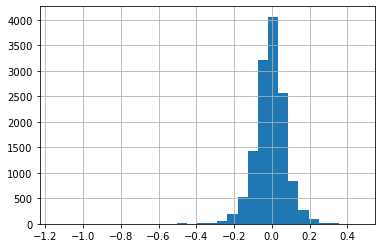

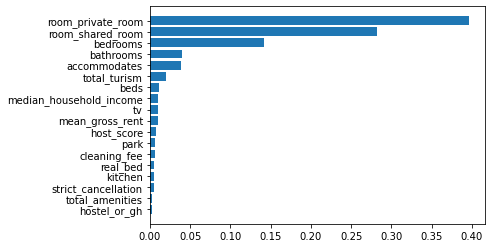

In [35]:
optimized_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'min_child_weight': 9,
    'max_depth': 7,
    'gamma': 0.0,
    'colsample_bytree': 0.7,
    'subsample': 0.9,
    'reg_alpha': 1,
    'n_estimators': 274,
    'missing': np.nan
}

model = xgb.XGBRegressor(**optimized_params)
model.fit(X_train,y_train.values.ravel())
y_train_pred = model.predict(X_train)
test_set = test_set.assign(y_predict = model.predict(X_test))

test_set = test_set.assign(
    error_abs = abs(test_set[y_var[0]]-test_set.y_predict),
    error_sqrt = (test_set[y_var[0]]-test_set.y_predict)**2,
    error_perc = (test_set[y_var[0]]-test_set.y_predict)/test_set[y_var[0]],
    error_perc_abs = abs((test_set[y_var[0]]-test_set.y_predict)/test_set[y_var[0]])
)

rmse_test = np.sqrt(test_set.error_sqrt.sum()/test_set.shape[0])
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mape = np.mean(test_set.error_perc_abs)
print('RMSE test: {}, RMSE train: {}, MAPE: {}%'.format(rmse_test, rmse_train, mape*100))
test_set.error_perc.hist(bins=30)

if model_type == 'non_linear':
    feature_df = pd.DataFrame([X_test.columns, model.feature_importances_]).T
    feature_df.columns = ['variable', 'feature_importance']
    feature_df = feature_df.sort_values('feature_importance', ascending=True)
    fig, ax = plt.subplots()
    ax.barh(feature_df.variable, feature_df.feature_importance)
else:
    coeficients = pd.DataFrame([list(X.columns), list(model.coef_)]).T
    coeficients.columns = ['variables', 'coeficients']
    coeficients.set_index('variables').sort_values('coeficients').plot(kind='barh')

In [36]:
test_set_features = test_set.reset_index().filter(
    ['id', 'error_perc', 'error_abs', 'y_predict'], axis=1
).merge(train_data, on='id', how='left')

# See if errors are related with another cat variable from our dataset
def plot_categorical_error(x_var):
    plt.figure(figsize=(20,7))
    sns.violinplot(x=x_var, y='error_perc', data=test_set_features)
    plt.title(x_var.replace('_',' '))

interact(plot_categorical_error, x_var=cat_variables)

# Check erros by location
if show_maps:
    test_ds = ColumnDataSource(test_set_features)
    mapper = LinearColorMapper(
        palette=viridis(256),
        low=test_set_features.error_abs.min(),
        high=test_set_features.error_abs.max()
    )
    map_options = GMapOptions(lat=37.774, lng=-122.431, map_type="roadmap", zoom=5)
    p = gmap(GOOGLE_API, map_options, title="Log prices")
    p.circle('longitude', 'latitude',
             source=test_ds,
             size=20,
             alpha=0.5,
             fill_color={"field":"error_abs", "transform":mapper}
            )
    show(p)

interactive(children=(Dropdown(description='x_var', options=('room_type', 'property_type', 'accommodates', 'ba…

# Test predictions 

In [37]:
test_lore = pd.read_csv(
    '../data/raw/test_lore.csv',
    parse_dates=['first_review','host_since', 'last_review']
)
test_lore = test_lore.assign(var = 'test_lore')
display(test_lore.shape[0])
test = pd.read_csv(
    '../data/raw/test.csv',
    parse_dates=['first_review','host_since', 'last_review']
)
display(test.shape[0])
test = test.assign(var = 'test')
test_data = pd.concat([test, test_lore])
display(test_data.shape[0])
household_data = pd.read_csv(
    '../data/processed/median_household_income_all.csv',
    usecols = ['id', 'median_household_income']
)
rent_data = pd.read_csv(
    '../data/processed/mean_gross_rent_all.csv',
    usecols = ['id', 'mean_gross_rent']
)
fs_data = pd.read_csv(
    '../data/processed/fs_agg_data_airbnb_id_entertainment1000m.csv',
    dtype={'GEOID':str},
    usecols=['GEOID', 'id', 'park']
)
fs_data_entertainment = pd.read_csv(
    '../data/processed/fs_agg_data_airbnb_id_turism700m.csv',
    dtype={'GEOID':str}
)
test_data = test_data.merge(household_data, on=['id'], how='left')
display(test_data.shape)
test_data = test_data.merge(fs_data, on=['id'], how='left')
display(test_data.shape)
test_data = test_data.merge(fs_data_entertainment, on=['id','GEOID'], how='left')
display(test_data.shape)
test_data = test_data.merge(rent_data, on=['id'], how='left')
display(test_data.shape)

7411

25458

32869

(32869, 31)

(32869, 33)

(32869, 34)

(32869, 35)

<AxesSubplot:>

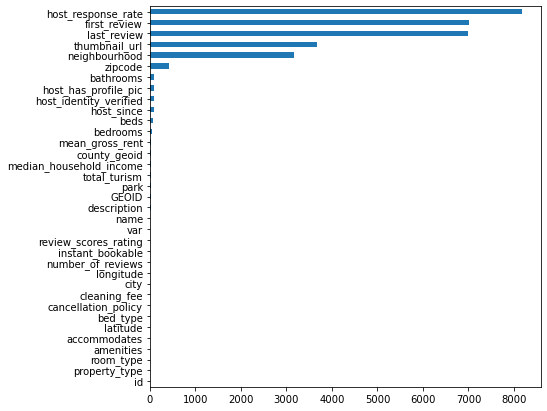

In [38]:
# Fill na
test_data = test_data.assign(county_geoid = test_data.GEOID.str.slice(0,5))
test_data = test_data.assign(
    review_scores_rating = test_data.review_scores_rating.fillna(20),
    median_household_income = test_data.median_household_income.fillna(
        test_data.groupby('county_geoid')['median_household_income'].transform('mean')),
    park = test_data.park.fillna(
        test_data.groupby('county_geoid')['park'].transform('mean')),
    mean_gross_rent = test_data.mean_gross_rent.fillna(
        test_data.groupby('county_geoid')['mean_gross_rent'].transform('mean')
    )
)
fig, axs = plt.subplots(figsize=(7,7))
test_data.drop(
    ['log_price'], 
    axis=1
).isnull().sum().sort_values(ascending=True).plot(kind='barh')

## Transform data

In [39]:
test_data = test_data.assign(
    amenities_list = test_data.amenities.str.replace(
    '{','').str.replace(
    '}','').str.replace(
    '"','').map(lambda x: x.split(',')),
)

In [40]:
model_amenities = ['TV', 'Kitchen']
for amenity in model_amenities:
    test_data[amenity] = 0
# Inputing 1 for listings that have the amenity
for index_label, row in test_data.iterrows():
    for amenity in model_amenities:
        if amenity in row.amenities_list:
            test_data.at[index_label, amenity] = 1
            
test_data.columns = [column.lower().replace(' ','_') for column in test_data.columns]

In [41]:
test_data = test_data.assign(
    real_bed = np.where(test_data.bed_type == 'Real Bed', 1, 0),
    hostel_or_gh = np.where(
        test_data.property_type.isin(['Hostel', 'Guesthouse']),
        1,0),
    strict_cancellation = np.where(
        test_data.cancellation_policy.isin(['super_strict_30', 'super_strict_30']), 1 ,0),
    host_identity_verified = np.where(test_data.host_identity_verified == 't',1,0),
    num_reviews_over_3 = np.where(test_data.number_of_reviews > 3, 1,0),
    review_rating_over_80 = np.where(test_data.review_scores_rating > 80, 1,0),
    total_amenities = np.log(test_data.amenities_list.map(lambda x: len(x)) + 1)
)

test_data = test_data.assign(
    host_score = 0.3 * test_data.host_identity_verified + \
    test_data.num_reviews_over_3 * 0.35 + test_data.review_rating_over_80 * 0.35
)
test_data = test_data.drop(['host_identity_verified', 'num_reviews_over_3', 'review_rating_over_80'], axis=1)

In [42]:
test_data_index = test_data.set_index(unique_id)
test_data_index['room_type'] = test_data_index[col].str.replace(' ','_').str.lower()
room_dummies = pd.get_dummies(test_data_index['room_type'], prefix='room', drop_first=True)
test_data_index[x_vars_bool] = test_data_index[x_vars_bool]*1
test_data_index[x_vars_cat_nt] = test_data_index[x_vars_cat_nt].astype(int)
data_model = test_data_index[x_vars + y_var]
data_model = pd.concat([data_model, room_dummies], axis=1)
data_model = data_model.drop(['room_type'],axis=1)

In [43]:
data_model = data_model.assign(
    y_predict = model.predict(data_model[X_test.columns])
)

In [44]:
predict_lore = data_model.query('~log_price.isnull()')
rmse = np.sqrt(mean_squared_error(predict_lore.log_price, predict_lore.y_predict))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 0.4074735402776267


In [45]:
rmse = np.sqrt(mean_squared_error(predict_lore.log_price, predict_lore.y_predict))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 0.4074735402776267


In [46]:
# Comparte parameter statistics
display(data_model[X_train.columns].describe())
display(X_train.describe())

,tv,real_bed,kitchen,strict_cancellation,hostel_or_gh,accommodates,bathrooms,bedrooms,median_household_income,park,total_amenities,beds,host_score,total_turism,mean_gross_rent,cleaning_fee,room_private_room,room_shared_room
count,32869.000000,32869.000000,32869.000000,32869.000000,32869.000000,32869.000000,32775.000000,32834.000000,32853.000000,32853.000000,32869.000000,32806.000000,32869.000000,32853.000000,32853.000000,32869.000000,32869.000000,32869.000000
mean,0.709605,0.972801,0.910524,0.001704,0.008032,3.152210,1.241037,1.267588,86083.492568,6.704715,2.843433,1.716180,0.654676,18.373695,1759.973517,0.735617,0.413855,0.032310
std,0.453952,0.162665,0.285435,0.041242,0.089262,2.134157,0.595615,0.848155,39676.975894,4.481711,0.441483,1.260328,0.357303,21.998581,553.633995,0.441011,0.492531,0.176825
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8264.000000,0.000000,0.693147,0.000000,0.000000,0.000000,289.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,54688.000000,3.000000,2.639057,1.000000,0.300000,2.000000,1360.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,80000.000000,6.000000,2.890372,1.000000,0.700000,10.000000,1706.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,111569.000000,10.000000,3.135494,2.000000,1.000000,27.000000,2114.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,15.500000,14.000000,250001.000000,25.000000,4.477337,40.000000,1.000000,100.000000,3501.000000,1.000000,1.000000,1.000000


,tv,real_bed,kitchen,strict_cancellation,hostel_or_gh,accommodates,bathrooms,bedrooms,median_household_income,park,total_amenities,beds,host_score,total_turism,mean_gross_rent,cleaning_fee,room_private_room,room_shared_room
count,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53211.000000,53290.000000,53328.000000,53328.000000,53359.000000,53264.000000,53359.000000,53328.000000,53328.000000,53359.000000,53359.000000,53359.00000
mean,0.706160,0.971551,0.911318,0.001349,0.007665,3.160816,1.235111,1.268230,86352.680526,6.753863,2.842181,1.712639,0.655899,18.563006,1760.538580,0.733447,0.411346,0.02933
std,0.455524,0.166253,0.284287,0.036709,0.087215,2.157256,0.584294,0.852872,39476.597941,4.481036,0.440439,1.262406,0.359719,21.965059,551.146819,0.442161,0.492082,0.16873
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8264.000000,0.000000,0.693147,0.000000,0.000000,0.000000,283.000000,0.000000,0.000000,0.00000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,55170.000000,3.000000,2.639057,1.000000,0.300000,2.000000,1363.000000,0.000000,0.000000,0.00000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,80484.000000,6.000000,2.890372,1.000000,0.700000,10.000000,1708.000000,1.000000,0.000000,0.00000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,111569.000000,10.000000,3.135494,2.000000,1.000000,28.000000,2111.000000,1.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,8.000000,10.000000,250001.000000,25.000000,4.465908,18.000000,1.000000,100.000000,3501.000000,1.000000,1.000000,1.00000


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

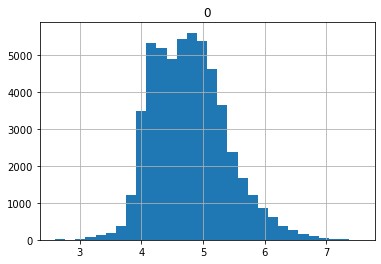

In [47]:
pd.DataFrame(y_train_pred).hist(bins=30)

<AxesSubplot:>

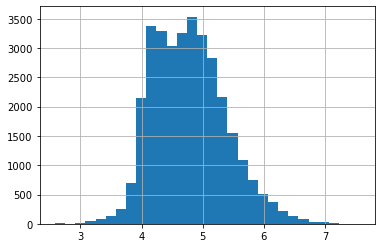

In [48]:
data_model.y_predict.hist(bins=30)

In [49]:
final_output = test[['id']].merge(data_model.reset_index().filter(['id', 'y_predict']), on='id', how='left')
final_output = final_output.rename(
    columns={'y_predict': 'log_price'}
)

25458

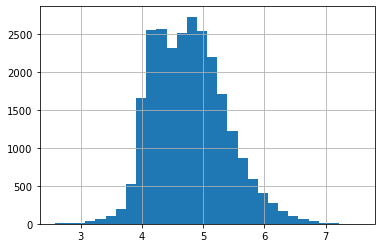

In [52]:
final_output.log_price.hist(bins=30)
display(final_output.shape[0])

In [50]:
final_output.to_csv(
    '../data/processed/final_predictions_lorena.csv',
    index=False
)